<center> <h1>Pseudo Rehearsal using non photo-realistic images </center>

This work is an implementation of the technique discussed in the paper titled <b>Pseudo rehearsal using non photo-realistic images.</b> The full paper can be found at this <a href="https://ieeexplore.ieee.org/document/9412827">link</a> and the arxiv preprint in this <a href="https://arxiv.org/abs/2004.13414">link.</a>

<h3>Introduction:</h3>
1. In this work, we try to establish that neural networks can be pseudo rehearsed on synthetic images that are not photo-realistic.<br>
2. Instead of using generative networks to generate photo-realistic synthetic data, in this work, we pseudo rehearse a neural network on non photo-realistic data generated using <b>Genetic Algorithms</b>.

<h3>Experiment</h3>
One simple experiment reported in the paper is replicated to keep the notebook short and within reach of computational resources available on google colab. <br>
1. In this experiment, we first train a neural network on MNIST Fashion dataset. <br>
2. Then, Genetic Algorithms is used to create synthetic data for Fashion dataset.<br>
3. We then train the same neural network on MNIST Digits dataset while pseudo rehearsing it on the synthetic data for MNIST Fashion that we just created using Genetic Algorithms.

The retention and learning behavior of the neural network is then observed.

<b>NOTE:</b> If you are using Google colab to run the notebook, please ensure that there is atleast 25GB of allocated RAM.




In [1]:
# This code was written for Tensorflow 1. 
# So please ensure that google colab uses Tensorflow 1 while executing the codes.
# Running this cell ensures that Tensorflow 1 is used.

%tensorflow_version 1.x

TensorFlow 1.x selected.


## Loading MNIST Fashion dataset

First, we load MNIST Fashion dataset. We reshape the dataset such that all the image samples are now flattened.

In [2]:
import keras
from keras.datasets import fashion_mnist
import numpy as np

(x_train_h, y_train_h), (x_test_h, y_test_h) = fashion_mnist.load_data()

x_train_h = x_train_h/255
x_test_h = x_test_h/255

y_train_h = np.copy(y_train_h)
y_test_h = np.copy(y_test_h)

x_train_h = np.reshape(x_train_h,(60000,28,28,1))
x_test_h = np.reshape(x_test_h,(10000,28,28,1))

pre_y_train_h = y_train_h
pre_y_test_h = y_test_h

y_test_h = keras.utils.to_categorical(y_test_h, 20)
y_train_h = keras.utils.to_categorical(y_train_h, 20)

x_train_h = np.reshape(x_train_h,(60000,784))
x_test_h = np.reshape(x_test_h,(10000,784))

Using TensorFlow backend.


## Initialize a neural network

For this tutorial, let us initialize a simple, fully connected neural network.

 Please note that the proposed technique is scalable to any type of classification network like CNN.

Feel free to plug in any other architecture of your choice. However, make sure that the parameters of the genetic algorithm are adjusted accordingly.

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation

model = Sequential()

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(20))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Train the network on MNIST Fashion


In [4]:
history_original = model.fit(x_train_h,y_train_h,verbose=1,epochs=5,batch_size=100)
score = model.evaluate(x_test_h,y_test_h,verbose=1)
print("\nAccuracy of the model on Fashion dataset: ",score[1]*100,"%")


Epoch 1/5
60000/60000 [==============================] - 7s 111us/step - loss: 0.5533 - accuracy: 0.7987
Epoch 2/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.3807 - accuracy: 0.8586
Epoch 3/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.3379 - accuracy: 0.8737
Epoch 4/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.3096 - accuracy: 0.8847
Epoch 5/5
10000/10000 [==============================] - 1s 68us/step

Accuracy of the model on Fashion dataset:  87.6200020313263 %


# Creating synthetic data for MNIST Fashion dataset from our model.

In this work, instead of using a separate neural structure to generate synthetic data, we use the neural network itself to generate synthetic data. We do this using Genetic Algorithms. To get a better understanding of the technique, please refer to the <a href="https://ieeexplore.ieee.org/document/9412827">paper</a>.

## Setting the parameters of the Genetic Algorithm

These parameters are responsible for altering the rate of convergence of the Genetic Algorithm. 

Play around with these parameters to see changes in increase or decrease in the rate of convergence of the algorithm.

You will also notice that rate of convergence is not the same for all classes, so you can try to set different parameters for different classes.

Note: If you plugged in your own network or a different dataset in the previous step, then change the parameters accordingly.

In [5]:
population_size=16
NUMBER_OF_CULTURES = 30
NUMBER_OF_GENERATIONS = 100
MUTATION_PROBABILITY = 0.1
MUTATION_TYPE = "+"

#Three times of mutations are possible. +,-,*.

## Declaring functions required for Genetic Algorithm

In [6]:
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
from heapq import nlargest
import random

def crossover(first_gene,second_gene,index):
  temp = np.copy(first_gene[index:])
  first_gene[index:] = second_gene[index:]
  second_gene[index:]=temp

def generate_labels(data,model,number_of_classes):
  '''
  . \n\n
  AUTHOR:
  Suri Bhasker Sri Harsha

  AIM:
  The function assigns labels to the given dataset with the given model as the reference.
  The function returns a list with labels in two formats. The first format is the one-hot encoding
  format and the second format is the binary format of labels.

  ARGUMENTS:
  data: The dataset for which you want to generate labels
  model: The model that will be used for the label generation
  number_of_classes: Number of classes in the dataset

  RETURNS:
  [labels, pre_labels]
  '''

  labels = model.predict_classes(data,verbose=1)
  pre_labels = labels
  labels = keras.utils.to_categorical(labels,number_of_classes)

  return [labels,pre_labels]
def agreement_score(model1_predictions, model2_predictions):

  '''
  Returns the degree of agreement between predictions of two models

  INPUT ARGUMENTS
  model1_predictions: Preditions of the model 1 on a test dataset
  model2_predictions: Preditions of the model 2 on a test dataset

  OUTPUT:
  Returns a list of two elements where the first elements is the
  "Agreement score" between the two lists and the second element
  is the list of indices where both the models have agreed upon.
  '''

  if len(model1_predictions) != len(model2_predictions):
    print("Length of given lists donot match")
    return 0

  correct_count = 0
  agreement_indices = []

  for i in range(len(model1_predictions)):
    if model1_predictions[i] == model2_predictions[i]:
      correct_count += 1
      agreement_indices.append(i)

  agreement_score = (correct_count/len(model1_predictions))*100

  return [agreement_score, agreement_indices]


def Enrichment(data,labels,model,NUMBER_OF_CENTERS,NUMBER_OF_CLASSES, NUMBER_OF_SAMPLES, verbose=0):
    '''
    Enriches the given data by fitting a Gaussian Mixture model with
    NUMBER_OF_CENTERS and NUMBER_OF_SAMPLES
    '''
    if verbose == 1:
        print("Creating the Gaussian mixture model ...")
    gaussian = GaussianMixture(n_components = NUMBER_OF_CENTERS)

    if verbose == 1:
        print("Created the model ...")

    if verbose == 1:
        print("Fitting the data to the GMM ...")
    gaussian.fit(X=data)

    if verbose == 1:
        print("Generating synthetic samples ....")
    synthetic = gaussian.sample(n_samples=NUMBER_OF_SAMPLES)

    synthetic_data = synthetic[0]

    if verbose == 1:
        print("Generating labels ...")
    labels = model.predict_classes(synthetic_data,verbose=1)
    pre_labels = labels
    labels = keras.utils.to_categorical(labels,NUMBER_OF_CLASSES)

    return [synthetic_data, labels, pre_labels]


In [ ]:
from heapq import nlargest
import random

pseudo_x_train_2400 = np.zeros((0,784))

POINTS_GATHERED = []
ideal_points = []

for class_number in range(10):
  POINTS_COUNTER=0
  print("Class number: ", class_number)

  for p in range(NUMBER_OF_CULTURES): 

    # CREATING THE INITIAL POPULATION 
    '''Here, the initial population is made of "zeros". Try different initial populations to see 
    how the evolution changes.'''
    current_generation=[]
    for i in range(population_size):
      current_generation.append(np.zeros((784)))
    
    best = 0
    best_list=[]

    '''The stopping criteria for the genetic algorithm can be set here.
    Currently, the algorithm runs till a fitness of 99% is reached by any organism,
    alternatively, it could be restricted based on the maximum number of generations for which 
    the algorithm can run.
    '''
    while best*100 < 99:
    # for generation_number in range(NUMBER_OF_GENERATIONS):

      current_generation_fitness=[]
      
      '''Finding the fitness of each organism in the current population'''
      for i in range(population_size):

        test_point = np.reshape(current_generation[i],(1,784))

        fitness_score = model.predict(test_point)[0][class_number]
        class_prediction= model.predict_classes(test_point)
        current_generation_fitness.append(fitness_score)

      if max(current_generation_fitness) >= best:
        best = max(current_generation_fitness)
      
      print("Best: ",best*100, " Culture number: ",p," Class number: ",class_number)
      

      '''Finding the indices of the fittest 25% organisms'''
      fittest_four_model_indices = nlargest(int(population_size/4), range(len(current_generation_fitness)), current_generation_fitness.__getitem__)
  
      # VERIFIED
      temp_list=[]
      for temp in range(int(population_size/4)):
        temp_list.append(np.copy(current_generation[fittest_four_model_indices[temp]]))
      

      # VERIFIED
      for temp in range(int(population_size/4)):
        current_generation[temp] = np.copy(temp_list[temp])
     
  
      '''Performing mutation operations on the current generation to create the next generation.'''
      # VERIFIED
      for temp in range((int(population_size/4)),(int(population_size/2))):
        current_generation[temp] = np.copy(current_generation[temp-(int(population_size/4))])     
  
      # VERIFIED
      for i in range((int(population_size/4)),(int(population_size/2))):
        point_mutation=np.random.choice([0,abs(np.random.normal(0,1,[1]))],size=current_generation[i].shape, p=[(1-MUTATION_PROBABILITY),MUTATION_PROBABILITY])

        if MUTATION_TYPE == "*":
          choice=random.choice(["+","-","*"])
          if choice== "-":
            current_generation[i] = current_generation[i] - point_mutation
          elif choice=="+":
            current_generation[i] = current_generation[i] + point_mutation
        elif MUTATION_TYPE == "+":
          current_generation[i] = current_generation[i] + point_mutation
        else:
          current_generation[i] = current_generation[i] - point_mutation
      
      
      '''Performing crossover operations on the current generation to create the next generation'''
      # VERIFIED
      for temp in range((int(population_size/2)),(int(population_size*0.75))):
        current_generation[temp] = np.copy(current_generation[temp-(int(population_size/2))])
     
  
      # VERIFIED
      for temp in range((int(population_size/2)),(int(population_size*0.75))):
        if temp%2 == 0:
          crossover(current_generation[temp],current_generation[temp+1],int((current_generation[temp].shape)[0]/2))
  
      '''Performing mutated-crossover of the current generation to create the next generation'''
      # VERIFIED
      for temp in range((int(population_size*0.75)),population_size):
        current_generation[temp] = np.copy(current_generation[temp-(int(population_size/2))])
  
      # VERIFIED
      for temp in range((int(population_size*0.75)),population_size):
        if temp%2 == 0:
          crossover(current_generation[temp],current_generation[temp+1],int((current_generation[temp].shape)[0]/2))
    for k in range(len(current_generation)):
      pseudo_x_train_2400 = np.vstack((pseudo_x_train_2400,np.reshape(current_generation[k],(1,784))))
    
print("Generated data: ",pseudo_x_train_2400.shape)

In [8]:
'''Since the synthetic data generated using Genetic Algorithms has no labels, we use our model to 
generate labels for them.'''

from sklearn.utils import class_weight

print(pseudo_x_train_2400.shape)

pseudo_y_train_2400 = model.predict_classes(pseudo_x_train_2400)

pre_pseudo_y_train_2400 = pseudo_y_train_2400
pseudo_y_train_2400 = keras.utils.to_categorical(pseudo_y_train_2400, 10)
print("Synthetic data shape: ",pseudo_x_train_2400.shape)
print("Synthetic labels shape: ",pseudo_y_train_2400.shape)

(4800, 784)
Synthetic data shape:  (4800, 784)
Synthetic labels shape:  (4800, 10)


In [9]:
# SANITY CHECK
'''Un-comment this to see the coverage for each class.'''

# count = [0,0,0,0,0,0,0,0,0,0]
# for i in range(pseudo_x_train_2400.shape[0]):
#   count[pre_pseudo_y_train_2400[i]]+=1

# print(count)
# print(sum(count))

'Un-comment this to see the coverage for each class.'

## Enriching the genetic data

### Enrichment step 1

In [10]:
help(Enrichment)

Help on function Enrichment in module __main__:

Enrichment(data, labels, model, NUMBER_OF_CENTERS, NUMBER_OF_CLASSES, NUMBER_OF_SAMPLES, verbose=0)
    Enriches the given data by fitting a Gaussian Mixture model with
    NUMBER_OF_CENTERS and NUMBER_OF_SAMPLES



In [11]:
NUMBER_OF_SAMPLES = int(pseudo_x_train_2400.shape[0])*2
temp = Enrichment(pseudo_x_train_2400,pseudo_y_train_2400,model,10,10,NUMBER_OF_SAMPLES=NUMBER_OF_SAMPLES)

synthetic_data = temp[0]
synthetic_labels = temp[1]

print("Training data shape: ",synthetic_data.shape)
print("Training labels shape: ",synthetic_labels.shape)

9600/9600 [==============================] - 0s 45us/step
Training data shape:  (9600, 784)
Training labels shape:  (9600, 10)


In [12]:
# Sanity check:
'''Un-comment this to see the coverage for each class.'''

# count = [0,0,0,0,0,0,0,0,0,0]
# for i in range(temp[2].shape[0]):
#   count[temp[2][i]] += 1

# print(count)
# print(sum(count))

'Un-comment this to see the coverage for each class.'

### Enrichment Step 2

Please ensure that there is sufficient RAM available to run this code. Insufficient RAM might lead to crashing of the notebook.

In [13]:
NUMBER_OF_SAMPLES = 1000000

temp = Enrichment(synthetic_data,synthetic_labels,model,1,20,NUMBER_OF_SAMPLES)

new_synthetic_data = temp[0]
new_synthetic_labels = temp[1]

print("Training data shape: ",new_synthetic_data.shape)
print("Training labels shape: ",new_synthetic_labels.shape)

1000000/1000000 [==============================] - 52s 52us/step
Training data shape:  (1000000, 784)
Training labels shape:  (1000000, 20)


In [ ]:
# Sanity check:
'''Un-comment this to see the coverage for each class.'''

# count = [0,0,0,0,0,0,0,0,0,0]
# for i in range(temp[2].shape[0]):
#   count[temp[2][i]] += 1

# print(count)
# print(sum(count))

'Un-comment this to see the coverage for each class.'

## Visualizing the generated images

Time to see how the generated images look like.

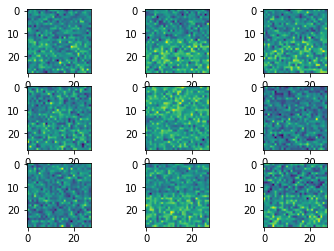

In [14]:
import matplotlib.pyplot as plt
import random

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(np.reshape(new_synthetic_data[i],(28,28)))

Now, after generating the synthetic data for MNIST Fashion, let us train the same neural network on MNIST Digits. We are going to mix the generated synthetic data with the training data of MNIST Digits.

# Loading MNIST Digits dataset

In [15]:
from keras.datasets import mnist
import copy

(x_train_f, y_train_f), (x_test_f, y_test_f) = mnist.load_data()

x_train_f = x_train_f/255
x_test_f = x_test_f/255

y_train_f = copy.deepcopy(y_train_f)
y_test_f = copy.deepcopy(y_test_f)

y_train_f += 10
y_test_f += 10

x_train_f = np.reshape(x_train_f,(60000,784))
x_test_f = np.reshape(x_test_f,(10000,784))

y_train_f = keras.utils.to_categorical(y_train_f,20)
y_test_f = keras.utils.to_categorical(y_test_f,20)

11493376/11490434 [==============================] - 1s 0us/step


# Training on digits while rehearsing fashion

In [16]:
print("Accuracy on MNIST Fashion: ",model.evaluate(x_test_h,y_test_h)[1])
print("Accuracy on MNIST Digits: ",model.evaluate(x_test_f,y_test_f)[1])

10000/10000 [==============================] - 1s 64us/step
Accuracy on MNIST Fashion:  0.8762000203132629
10000/10000 [==============================] - 1s 71us/step
Accuracy on MNIST Digits:  0.0


In [17]:
EPOCHS = 5

learning_accuracy = []
retention_accuracy = []

for epoch in range(EPOCHS):
  print("\n Epoch number: ",epoch)
  model.fit(x_train_f,y_train_f,epochs=1,batch_size=100,verbose=1)
  model.fit(new_synthetic_data,new_synthetic_labels,verbose=1,epochs=1,batch_size=1000,shuffle=True)
  
  learning_accuracy.append(model.evaluate(x_test_f,y_test_f,verbose=1)[1])
  retention_accuracy.append(model.evaluate(x_test_h,y_test_h,verbose=1)[1])



 Epoch number:  0
Epoch 1/1
60000/60000 [==============================] - 7s 110us/step - loss: 0.3051 - accuracy: 0.9147
Epoch 1/1
10000/10000 [==============================] - 1s 74us/step

 Epoch number:  1
Epoch 1/1
60000/60000 [==============================] - 6s 105us/step - loss: 0.1089 - accuracy: 0.9676
Epoch 1/1
10000/10000 [==============================] - 1s 70us/step

 Epoch number:  2
Epoch 1/1
60000/60000 [==============================] - 6s 108us/step - loss: 0.0709 - accuracy: 0.9789
Epoch 1/1
10000/10000 [==============================] - 1s 66us/step

 Epoch number:  3
Epoch 1/1
60000/60000 [==============================] - 6s 105us/step - loss: 0.0528 - accuracy: 0.9837
Epoch 1/1
10000/10000 [==============================] - 1s 70us/step

 Epoch number:  4
Epoch 1/1
60000/60000 [==============================] - 6s 104us/step - loss: 0.0390 - accuracy: 0.9884
Epoch 1/1
10000/10000 [==============================] - 1s 73us/step


In [ ]:
print("Accuracy on MNIST Fashion: ",model.evaluate(x_test_h,y_test_h)[1])
print("Accuracy on MNIST Digits: ",model.evaluate(x_test_f,y_test_f)[1])

10000/10000 [==============================] - 1s 55us/step
Accuracy on MNIST Fashion:  0.8169999718666077
10000/10000 [==============================] - 1s 55us/step
Accuracy on MNIST Digits:  0.9587000012397766


You should observe an accuracy of around 80% for Fashion and 97% for Digits dataset. The accuracy on Fashion will be retained at about 80% even if we continue the training for 25 more epochs. This technique was tested on MNIST Fashion, MNIST Digits, CIFAR10 and SVHN dataset. Near-perfect retention was observed for CIFAR10 and SVHN datasets. It is still unclear why the technique achieves <b>near perfect retention</b> for some datasets while having a slight drop for others. This can be a good direction to investigate in the future. 

Now to see how the retention of the neural network is without rehearsing on synthetic data, let us train the neural network for 5 more epochs on MNIST Digits and record its accuracy on Fashion and Digits. 

In [18]:
model.fit(x_train_f,y_train_f,epochs=5,batch_size=100,verbose=1)
print("Accuracy on MNIST Fashion: ",model.evaluate(x_test_h,y_test_h)[1])
print("Accuracy on MNIST Digits: ",model.evaluate(x_test_f,y_test_f)[1])

Epoch 1/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0300 - accuracy: 0.9909
Epoch 2/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.0185 - accuracy: 0.9947
Epoch 3/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.0136 - accuracy: 0.9963
Epoch 4/5
60000/60000 [==============================] - 6s 104us/step - loss: 0.0092 - accuracy: 0.9977
Epoch 5/5
10000/10000 [==============================] - 1s 72us/step
Accuracy on MNIST Fashion:  0.6237000226974487
10000/10000 [==============================] - 1s 60us/step
Accuracy on MNIST Digits:  0.9804999828338623


A significant drop in retention of Fashion dataset can be observed when we do not rehearse it.

# Concluding remarks

This tutorial tried to demonstrate that neural networks can be pseudo rehearsed on synthetic data that is not photo-realistic. This comes in handy when we are trying to generate synthetic data for visually complex datasets like CIFAR10. In the original paper, the technique was demonstrated on MNIST Fashion, CIFAR10 and SVHN datasets. 

It is suggested to try generating synthetic data for other datasets as well! Make sure to play around with the parameters when you change the dataset. You might not find the optimal parameters for Genetic Algorithms on the first try, but please remember that, as of now, there is no theoretical framework/technique to estimate the optimal parameters for genetic algorithms. So keep playing around and use your intuition.


In [ ]:
# This is being done to save space and prevent the program from crashing

# del new_synthetic_data
# del new_synthetic_labels

## Cite this work as:

@inproceedings{suri2021pseudo,<br>
  title={Pseudo Rehearsal using non photo-realistic images},<br>
  author={Suri, Bhasker Sri Harsha and Yeturu, Kalidas},<br>
  booktitle={2020 25th International Conference on Pattern Recognition (ICPR)},<br>
  pages={4797--4804},<br>
  year={2021},<br>
  organization={IEEE}}

The full paper can be found at this <a href=" https://ieeexplore.ieee.org/document/9412827">link</a> and a pre-print version of it can be found <a href="https://arxiv.org/abs/2004.13414">here</a>.

<u>Author of this notebook:</u>

Name: Suri Bhasker Sri Harsha<br>
Affiliation: Indian Institute of Technology Tirupati<br>
Email: cs18s506@iittp.ac.in